In [5]:
import pandas as pd

# Crime ML by <Anette> Leslie PyhonAi ITHS 2024

Some INFO about my ML:

1. I will use a lot of print for functions and command's, just to understand everything I do and what kind of data I get
2. The tools i will use for this ML are sckit-learn, numpy and mathplotlib.
3. The Model I will Train is a logistic regression model, because that feels more easy  for a beginner.


*What do i want to Accomplish:*

Can we predict in which city special crime will increase and therefore take more measures like increasing the police force, cameras and so on to stop crime in this area!


*My Problem with my data:*

I downloaded statistics from BRÅ (https://statistik.bra.se/solwebb/action/index ).
Picked some data I wanted to focus on, like in different counties in Stockholm and the crimes of violence against people.




Here is a example how the data looks:

Region;Brott;�r;Period;Antal;/100 000 inv
Stockholm kommun;Brott mot brottsbalken;2022;Jan;11322;1153;
Stockholm kommun;Brott mot brottsbalken;2022;Feb;12199;1243;

I have a few problems I need to solve with this data, here is a list of those problems:

1. This data uses Swedish letters, another type of unicode
2. I will work more to a regression problem, because the data i use will be more a prediction on a linear scale.
3. Which data is most important to USE for predicting the outcome?
4. Have 4 files with different year, how to put these together without copy paste
5. I need to label the data so its readable for the ML
6. Need to create a lag Feature because working with year and months

*Conclusion*

Below i will work with my data and try to solve the problems that i have with it.

In [6]:
# Testing one file
#df = pd.read_csv('../data/Databasfil2020.txt', encoding="ISO-8859-1", sep=";", index_col=False )


import functools
import glob

# Preparing data
data = pd.concat(map(functools.partial(pd.read_csv, encoding="ISO-8859-1", sep=";", index_col=False ), glob.glob("data/*.txt")))
data.drop(columns=['/100 000 inv'], axis=1, inplace=True)
data

,Region,Brott,År,Period,Antal
0,Botkyrka kommun,3-7 kap. Brott mot person,2021,Jan,241
1,Botkyrka kommun,3-7 kap. Brott mot person,2021,Feb,238
2,Botkyrka kommun,3-7 kap. Brott mot person,2021,Mar,196
3,Botkyrka kommun,3-7 kap. Brott mot person,2021,Apr,242
4,Botkyrka kommun,3-7 kap. Brott mot person,2021,Maj,254
...,...,...,...,...,...
5539,Österåker kommun,7 kap. Brott mot familj,2023 prel.,Aug,0
5540,Österåker kommun,7 kap. Brott mot familj,2023 prel.,Sep,0
5541,Österåker kommun,7 kap. Brott mot familj,2023 prel.,Okt,0
5542,Österåker kommun,7 kap. Brott mot familj,2023 prel.,Nov,0


In [7]:
# Define a mapping of Swedish month names to English month names
swedish_to_english_month = {
    'Jan': 'Jan',
    'Feb': 'Feb',
    'Mar': 'Mar',
    'Apr': 'Apr',
    'Maj': 'May', 
    'Jun': 'Jun',
    'Jul': 'Jul',
    'Aug': 'Aug',
    'Sep': 'Sep',
    'Okt': 'Oct',
    'Nov': 'Nov',
    'Dec': 'Dec',

}

# Redo Month namne to month numbers
data['Month'] = data['Period'].apply(lambda x: swedish_to_english_month[x])
data['Month'] = pd.to_datetime(data['Month'], format='%b').dt.month
data.drop(columns=['Period'], axis=1, inplace=True)
data


,Region,Brott,År,Antal,Month
0,Botkyrka kommun,3-7 kap. Brott mot person,2021,241,1
1,Botkyrka kommun,3-7 kap. Brott mot person,2021,238,2
2,Botkyrka kommun,3-7 kap. Brott mot person,2021,196,3
3,Botkyrka kommun,3-7 kap. Brott mot person,2021,242,4
4,Botkyrka kommun,3-7 kap. Brott mot person,2021,254,5
...,...,...,...,...,...
5539,Österåker kommun,7 kap. Brott mot familj,2023 prel.,0,8
5540,Österåker kommun,7 kap. Brott mot familj,2023 prel.,0,9
5541,Österåker kommun,7 kap. Brott mot familj,2023 prel.,0,10
5542,Österåker kommun,7 kap. Brott mot familj,2023 prel.,0,11


In [8]:
# Fix 2023 prel. to only 2023

old = {'2023 prel.': '2023'}

data.replace(old, regex=True, inplace=True)
data['Year'] = data['År'].astype(int)
data.drop(columns=['År'], axis=1, inplace=True)
data

,Region,Brott,Antal,Month,Year
0,Botkyrka kommun,3-7 kap. Brott mot person,241,1,2021
1,Botkyrka kommun,3-7 kap. Brott mot person,238,2,2021
2,Botkyrka kommun,3-7 kap. Brott mot person,196,3,2021
3,Botkyrka kommun,3-7 kap. Brott mot person,242,4,2021
4,Botkyrka kommun,3-7 kap. Brott mot person,254,5,2021
...,...,...,...,...,...
5539,Österåker kommun,7 kap. Brott mot familj,0,8,2023
5540,Österåker kommun,7 kap. Brott mot familj,0,9,2023
5541,Österåker kommun,7 kap. Brott mot familj,0,10,2023
5542,Österåker kommun,7 kap. Brott mot familj,0,11,2023


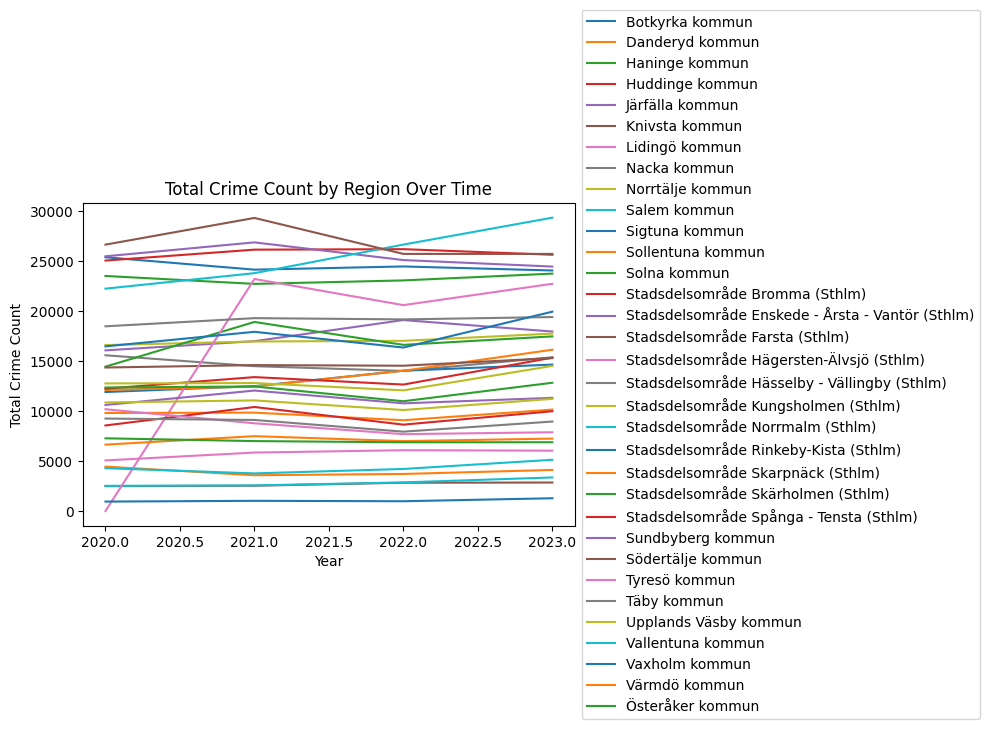

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Check unique regions in the dataset
unique_regions = data['Region'].unique()
#print("Unique Regions:", unique_regions)

# Group data by 'Region' and 'Year', summing the crime counts for each year
crime_counts = data.groupby(['Region', 'Year'])['Antal'].sum().reset_index()

# Print first few rows of crime_counts to inspect
#print(crime_counts.head())

# Plot data for all regions
plt.figure(figsize=(10, 6))
for region, region_data in crime_counts.groupby('Region'):
    plt.plot(region_data['Year'], region_data['Antal'], label=region)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Total Crime Count')
plt.title('Total Crime Count by Region Over Time')

# Add legend and position it in the upper left corner
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# Show plot
plt.tight_layout()
plt.show()


In [10]:
from sklearn.preprocessing import LabelEncoder


# Need to encode Region and Crime to english and a number, because i have a lot ot the same values
label_encoder = LabelEncoder()
data['Region'] = label_encoder.fit_transform(data['Region'])
data['Crime'] = label_encoder.fit_transform(data['Brott'])
data.drop(columns=['Brott'], axis=1, inplace=True)
data

,Region,Antal,Month,Year,Crime
0,0,241,1,2021,1
1,0,238,2,2021,1
2,0,196,3,2021,1
3,0,242,4,2021,1
4,0,254,5,2021,1
...,...,...,...,...,...
5539,32,0,8,2023,5
5540,32,0,9,2023,5
5541,32,0,10,2023,5
5542,32,0,11,2023,5


In [11]:
# We need to create lag features to representing historical crime data for each region and crime type.

 # Sort the data by region, crime type, and date
data.sort_values(by=['Region', 'Crime', 'Year', 'Month'], inplace=True)
data

,Region,Antal,Month,Year,Crime
24,0,118,1,2020,0
48,0,118,1,2020,0
25,0,97,2,2020,0
49,0,97,2,2020,0
26,0,87,3,2020,0
...,...,...,...,...,...
5443,32,16,8,2023,6
5444,32,20,9,2023,6
5445,32,18,10,2023,6
5446,32,20,11,2023,6


In [12]:
# Defining the maximum lag period (e.g., 12 months)
max_lag_period = 12

# Create lag features for the target variable 'Antal'
for lag in range(1, max_lag_period + 1):
    data[f'Antal_lag_{lag}'] = data.groupby(['Region', 'Crime'])['Antal'].shift(lag)

data

,Region,Antal,Month,Year,Crime,Antal_lag_1,Antal_lag_2,Antal_lag_3,Antal_lag_4,Antal_lag_5,Antal_lag_6,Antal_lag_7,Antal_lag_8,Antal_lag_9,Antal_lag_10,Antal_lag_11,Antal_lag_12
24,0,118,1,2020,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,0,118,1,2020,0,118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,0,97,2,2020,0,118.0,118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,0,97,2,2020,0,97.0,118.0,118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,0,87,3,2020,0,97.0,97.0,118.0,118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5443,32,16,8,2023,6,17.0,18.0,26.0,27.0,23.0,20.0,30.0,20.0,17.0,21.0,12.0,18.0
5444,32,20,9,2023,6,16.0,17.0,18.0,26.0,27.0,23.0,20.0,30.0,20.0,17.0,21.0,12.0
5445,32,18,10,2023,6,20.0,16.0,17.0,18.0,26.0,27.0,23.0,20.0,30.0,20.0,17.0,21.0
5446,32,20,11,2023,6,18.0,20.0,16.0,17.0,18.0,26.0,27.0,23.0,20.0,30.0,20.0,17.0


In [13]:
# Drop rows with NaN values resulting from shifting
data.dropna(inplace=True)
data

,Region,Antal,Month,Year,Crime,Antal_lag_1,Antal_lag_2,Antal_lag_3,Antal_lag_4,Antal_lag_5,Antal_lag_6,Antal_lag_7,Antal_lag_8,Antal_lag_9,Antal_lag_10,Antal_lag_11,Antal_lag_12
30,0,99,7,2020,0,125.0,125.0,106.0,106.0,105.0,105.0,87.0,87.0,97.0,97.0,118.0,118.0
54,0,99,7,2020,0,99.0,125.0,125.0,106.0,106.0,105.0,105.0,87.0,87.0,97.0,97.0,118.0
31,0,59,8,2020,0,99.0,99.0,125.0,125.0,106.0,106.0,105.0,105.0,87.0,87.0,97.0,97.0
55,0,59,8,2020,0,59.0,99.0,99.0,125.0,125.0,106.0,106.0,105.0,105.0,87.0,87.0,97.0
32,0,106,9,2020,0,59.0,59.0,99.0,99.0,125.0,125.0,106.0,106.0,105.0,105.0,87.0,87.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5443,32,16,8,2023,6,17.0,18.0,26.0,27.0,23.0,20.0,30.0,20.0,17.0,21.0,12.0,18.0
5444,32,20,9,2023,6,16.0,17.0,18.0,26.0,27.0,23.0,20.0,30.0,20.0,17.0,21.0,12.0
5445,32,18,10,2023,6,20.0,16.0,17.0,18.0,26.0,27.0,23.0,20.0,30.0,20.0,17.0,21.0
5446,32,20,11,2023,6,18.0,20.0,16.0,17.0,18.0,26.0,27.0,23.0,20.0,30.0,20.0,17.0
